In [1]:
# Run this again after editing submodules so Colab uses the updated versions
from citylearn import CityLearn
from pathlib import Path

from TD3 import TD3 as Agent

import sys
import warnings

import numpy as np
import pandas as pd

if not sys.warnoptions:
    warnings.simplefilter("ignore")

# Load environment
climate_zone = 5
params = {
    "data_path": Path("data/Climate_Zone_" + str(climate_zone)),
    "building_attributes": "building_attributes.json",
    "weather_file": "weather_data.csv",
    "solar_profile": "solar_generation_1kW.csv",
    "carbon_intensity": "carbon_intensity.csv",
    "building_ids": ["Building_" + str(i) for i in [1, 2, 3, 4, 5, 6, 7, 8, 9]],
    "buildings_states_actions": "buildings_state_action_space.json",
    "simulation_period": (0, 8760 * 4 - 1),
    "cost_function": [
        "ramping",
        "1-load_factor",
        "average_daily_peak",
        "peak_demand",
        "net_electricity_consumption",
        "carbon_emissions",
    ],
    "central_agent": False,
    "save_memory": False,
}

# Contain the lower and upper bounds of the states and actions, to be provided to the agent to normalize the variables between 0 and 1.
env = CityLearn(**params)
observations_spaces, actions_spaces = env.get_state_action_spaces()

# Provides information on Building type, Climate Zone, Annual DHW demand, Annual Cooling Demand, Annual Electricity Demand, Solar Capacity, and correllations among buildings
building_info = env.get_building_information()


params_agent = {
    "building_ids": ["Building_" + str(i) for i in [1, 2, 3, 4, 5, 6, 7, 8, 9]],
    "buildings_states_actions": "buildings_state_action_space.json",
    "building_info": building_info,
    "observation_spaces": observations_spaces,
    "action_spaces": actions_spaces,
}

In [13]:
# Instantiating the control agent(s)
# agents = Agent(**params_agent)
RBC_THRESHOLD = 48
agents = Agent(
    num_actions=actions_spaces,
    num_buildings=len(observations_spaces),
    env=env,
    rbc_threshold=RBC_THRESHOLD,
)

state = env.reset()
done = False

action = agents.select_action(state)

t_idx = 0
end_time = RBC_THRESHOLD + 24 * 7

while not done and t_idx <= end_time:

    next_state, reward, done, _ = env.step(action)
    action_next = agents.select_action(
        next_state, env
    )  # passing in environment for Oracle agent.
    agents.add_to_buffer_oracle(env, action, reward)
    # agents.add_to_buffer(state, action, reward, next_state, done)
    state = next_state
    action = action_next

    t_idx += 1
    
    print(f"\rTime step: {agents.total_it}", end="")

# env.cost()


Time step: 95Critic update time (sec): 51.79179787635803
Time step: 191Critic update time (sec): 52.14541816711426
Time step: 217

### Plotting

In [14]:
import matplotlib.pyplot as plt

In [15]:
### TODO: insert code here

In [35]:
rewards = np.zeros(shape=(7, 24, 9)) # days, hours, buildings
for i, day in enumerate(agents.memory.replay_memory):
    _reward = np.array(day["reward"])
    rewards[i] = _reward
rewards = rewards.reshape((7 * 24, 9))

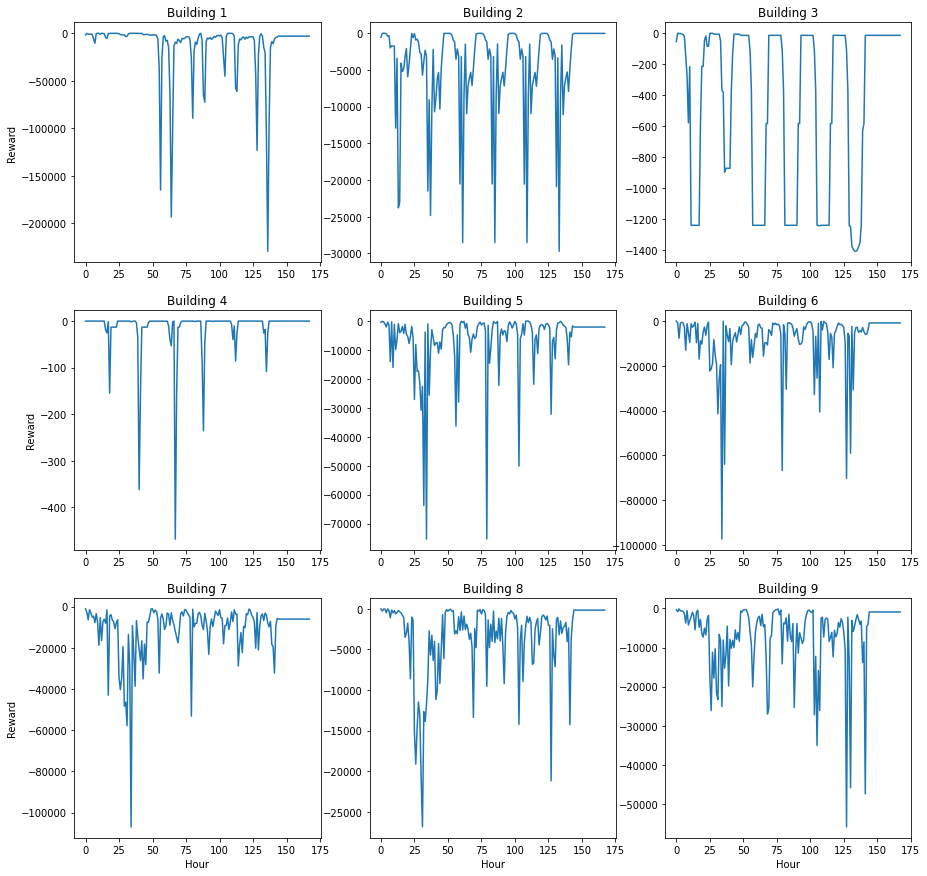

In [57]:
# using the variable axs for multiple Axes
fig, axs = plt.subplots(3, 3, figsize=(15, 15)) # 9 buildings

id = 0
for r in range(3):
    for c in range(3):
        axs[r, c].plot(rewards[:, id])
        axs[r, c].set_title(f"Building {id + 1}")
        id += 1
        
# set labels
plt.setp(axs[-1, :], xlabel='Hour')
plt.setp(axs[:, 0], ylabel='Reward')

plt.show()